<a href="https://colab.research.google.com/github/Abhishek500/ERA/blob/main/S7/ERA_S7_C6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/ERA V1')
from model import *

Mounted at /content/drive


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ElasticTransform(alpha=50.0, sigma=5.0),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 145426570.00it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 118644166.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41349632.28it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3571527.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model5().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
         Dropout2d-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
         Dropout2d-6           [-1, 10, 24, 24]               0
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 10, 10, 10]             910
       BatchNorm2d-9           [-1, 10, 10, 10]              20
        Dropout2d-10           [-1, 10, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           1,456
      BatchNorm2d-12             [-1, 16, 8, 8]              32

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    #return test_loss

In [9]:
import torch.optim.lr_scheduler as lr_scheduler

model = Model5().to(device)
max_lr=0.5
optimizer = optim.SGD(model.parameters(),lr=max_lr/25,momentum=0.9)
EPOCHS = 15
# Create the OneCycleLR scheduler
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader),pct_start=0.4, three_phase=True, epochs=EPOCHS)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.2041035145521164 Batch_id=468 Accuracy=88.74: 100%|██████████| 469/469 [02:49<00:00,  2.77it/s]



Test set: Average loss: 0.0422, Accuracy: 9860/10000 (98.60%)

EPOCH: 1


Loss=0.11538967490196228 Batch_id=468 Accuracy=96.24: 100%|██████████| 469/469 [02:48<00:00,  2.78it/s]



Test set: Average loss: 0.0343, Accuracy: 9895/10000 (98.95%)

EPOCH: 2


Loss=0.1021437719464302 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [02:49<00:00,  2.76it/s]



Test set: Average loss: 0.0305, Accuracy: 9903/10000 (99.03%)

EPOCH: 3


Loss=0.06580668687820435 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [02:52<00:00,  2.71it/s]



Test set: Average loss: 0.0290, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.130043163895607 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [02:56<00:00,  2.66it/s]



Test set: Average loss: 0.0271, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.025969786569476128 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [03:02<00:00,  2.57it/s]



Test set: Average loss: 0.0253, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.1810109168291092 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [02:58<00:00,  2.63it/s]



Test set: Average loss: 0.0244, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.20299752056598663 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [02:48<00:00,  2.79it/s]



Test set: Average loss: 0.0225, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.078712098300457 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [02:51<00:00,  2.73it/s]



Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.016627123579382896 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [02:47<00:00,  2.79it/s]



Test set: Average loss: 0.0234, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.11828682571649551 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [02:47<00:00,  2.80it/s]



Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.06102199852466583 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [02:46<00:00,  2.81it/s]



Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.048729583621025085 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [02:45<00:00,  2.83it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.12929695844650269 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [02:44<00:00,  2.84it/s]



Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.14269588887691498 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [02:47<00:00,  2.80it/s]



Test set: Average loss: 0.0186, Accuracy: 9948/10000 (99.48%)



Text(0.5, 1.0, 'Test Accuracy')

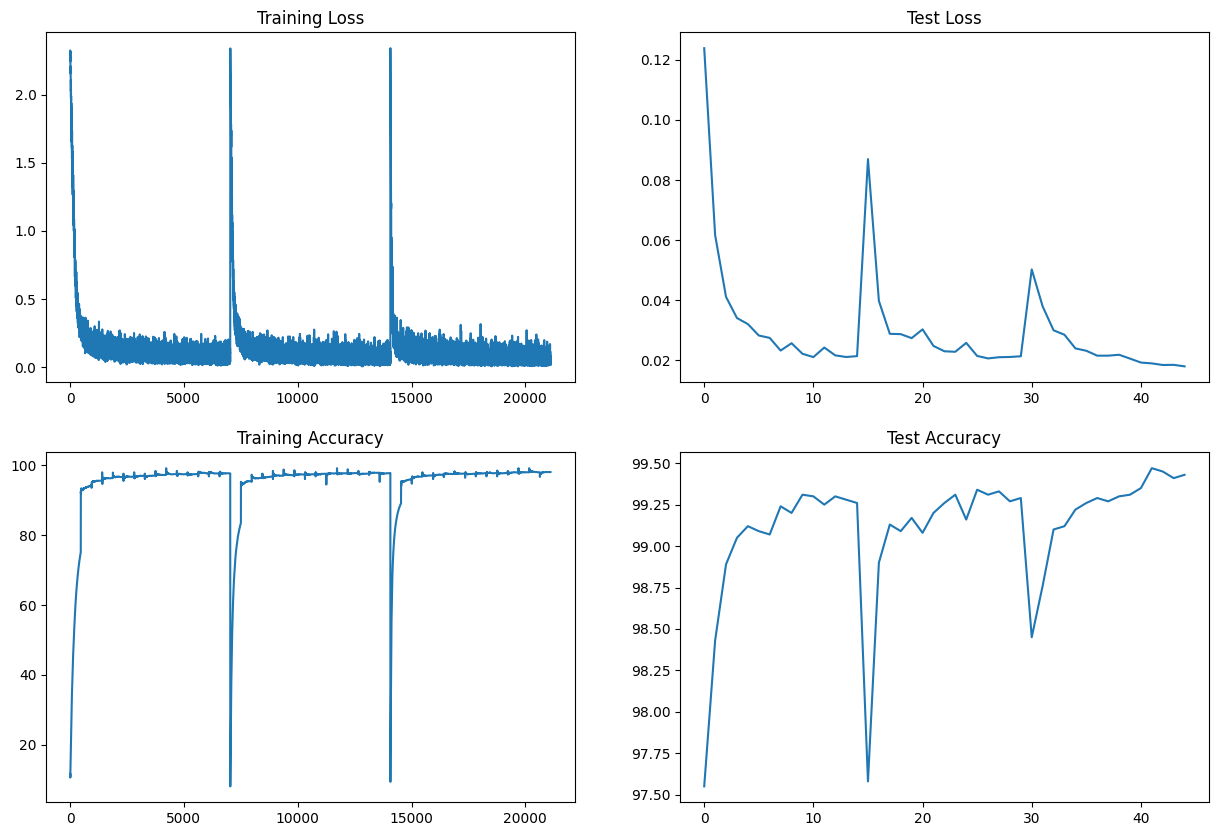

In [ ]:
import matplotlib.pyplot as plt

t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target:**


1.   Introduce BN, lower the batch size and increase LR along with a schedule



**Result:**

1.   Parameter: 8,342
2.   Best Training Accuracy: 98.06
3.   Best Test Accuracy: 99.48


**Analysis:**


1.  Used One Cycle policy. This led to improvement in the accuracy using same augmentation and model.
